In [ ]:
!pip install neuralforecast
!pip install feature-engine

In [ ]:
import os
import sys
import math
import pandas as pd
import numpy as np
from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS
from sklearn.metrics import mean_squared_error, mean_absolute_error
from neuralforecast.losses.numpy import mase as mase_numpy
from utilsforecast.losses import mase
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from neuralforecast.losses.pytorch import MAE
import sklearn
import neuralforecast
import feature_engine

In [ ]:
# Versões
print('Versões:')
print('Python: %s' % sys.version)
print('Pandas: %s' % pd.__version__)
print('Numpy: %s' % np.__version__)
print('Sklearn: %s' % sklearn.__version__)
print('NeuralForecast: %s' % neuralforecast.__version__)
print('Feature-Engine: %s' % feature_engine.__version__)

In [ ]:
ROOT = "/content/drive/MyDrive/dl-project"

FEATURES = [
    'pressure_1',
    'pressure_2',
    'pressure_3',
    'pressure_4',
    'pressure_5',
    'pressure_6',
    'pressure_7'
]
SEED = 78

horizon = 187
input_size = 187

In [ ]:
train = pd.read_csv(f"{ROOT}/data/train_data_scaled.csv")
test = pd.read_csv(f"{ROOT}/data/test_data_scaled.csv")

In [ ]:
# Requrimento do nixtla
train['unique_id'] = 'slug_flow'
train['ds'] = train['time']
train['y'] = train['liquid_flow_rate']


test['unique_id'] = 'slug_flow'
test['ds'] = test['time']
test['y'] = test['liquid_flow_rate']

In [ ]:
nhits_config = AutoNHITS.get_default_config(h = horizon, backend="ray")
nhits_config.update(
    {
        'input_size': input_size,
        'exclude_insample_y': True,
        'hist_exog_list': FEATURES,
        'early_stop_patience_steps': 10,
        'val_check_steps': 100,
        'random_seed': SEED
    }
)
nhits_config

{'h': None,
 'n_pool_kernel_size': <ray.tune.search.sample.Categorical at 0x7f7bd0508ed0>,
 'n_freq_downsample': <ray.tune.search.sample.Categorical at 0x7f7bd0509150>,
 'learning_rate': <ray.tune.search.sample.Float at 0x7f7bd0509210>,
 'scaler_type': <ray.tune.search.sample.Categorical at 0x7f7bd0509310>,
 'max_steps': <ray.tune.search.sample.Float at 0x7f7bd0509090>,
 'batch_size': <ray.tune.search.sample.Categorical at 0x7f7bd0509510>,
 'windows_batch_size': <ray.tune.search.sample.Categorical at 0x7f7bd0509610>,
 'loss': None,
 'random_seed': 78,
 'input_size': <ray.tune.search.sample.Categorical at 0x7f7bd0573f90>,
 'step_size': <ray.tune.search.sample.Categorical at 0x7f7bd258fa10>,
 'exclude_insample_y': True,
 'hist_exog_list': ['pressure_1',
  'pressure_2',
  'pressure_3',
  'pressure_4',
  'pressure_5',
  'pressure_6',
  'pressure_7'],
 'early_stop_patience_steps': 10,
 'val_check_steps': 100}

### Training

In [ ]:
models = [
    AutoNHITS(
        h=horizon,
        loss=MAE(),
        config=nhits_config,
        search_alg=HyperOptSearch(),
        backend='ray',
        num_samples=30
    )
]

In [ ]:
nf = NeuralForecast(
    models=models,
    freq=1
)
nf.fit(
    df=train, val_size=horizon
)

2025-06-15 17:27:59,797	INFO worker.py:1917 -- Started a local Ray instance.
2025-06-15 17:28:01,541	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2025-06-15_17-27-55   |
+--------------------------------------------------------------------+
| Search algorithm                 SearchGenerator                   |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 30                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2025-06-15_17-27-55
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-06-15_17-27-55_986760_192/artifacts/2025-06-15_17-28-01/_train_tune_2025-06-15_17-27-55/driver_artifacts`


(_train_tune pid=1422) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=1422) Seed set to 78
(_train_tune pid=1422) GPU available: False, used: False
(_train_tune pid=1422) TPU available: False, using: 0 TPU cores
(_train_tune pid=1422) HPU available: False, using: 0 HPUs
(_train_tune pid=1422) 2025-06-15 17:28:15.749325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=1422) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=1422) E0000 00:00:1750008496.035796    1515 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one h

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  6.81it/s, v_num=0, train_loss_step=0.0381, train_loss_epoch=0.0372]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  6.64it/s, v_num=0, train_loss_step=0.0283, train_loss_epoch=0.0292, valid_loss=0.00933]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  6.76it/s, v_num=0, train_loss_step=0.0201, train_loss_epoch=0.022, valid_loss=0.00836]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  6.86it/s, v_num=0, train_loss_step=0.0199, train_loss_epoch=0.0198, valid_loss=0.00696]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s, v_num=0, train_loss_step=0.0147, train_loss_epoch=0.0148, valid_loss=0.00775]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s, v_num=0, 

2025-06-15 17:33:01,763	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (24, 12, 1), 'n_pool_kernel_size': (1, 1, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 1399:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.00755, train_loss_epoch=0.00755, valid_loss=0.00391]


(_train_tune pid=1422) `Trainer.fit` stopped: `max_steps=1400.0` reached.


Epoch 1399: 100%|██████████| 1/1 [00:00<00:00,  5.49it/s, v_num=0, train_loss_step=0.00756, train_loss_epoch=0.00755, valid_loss=0.00391]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1399: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=0, train_loss_step=0.00756, train_loss_epoch=0.00756, valid_loss=0.00356]


(_train_tune pid=2744) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=2744) Seed set to 78
(_train_tune pid=2744) GPU available: False, used: False
(_train_tune pid=2744) TPU available: False, using: 0 TPU cores
(_train_tune pid=2744) HPU available: False, using: 0 HPUs
(_train_tune pid=2744) 2025-06-15 17:33:14.647871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=2744) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=2744) E0000 00:00:1750008794.677098    2833 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one h

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, v_num=0, train_loss_step=0.0167, train_loss_epoch=0.0138]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s, v_num=0, train_loss_step=0.0134, train_loss_epoch=0.00751, valid_loss=0.0387] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, v_num=0, train_loss_step=0.00564, train_loss_epoch=0.00365, valid_loss=0.0249]
(_train_tune pid=2744) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=2744) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, v_num=0, train_loss_step=0.00461, train_loss_epoch=0.00492, valid_loss=0.0321]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.69it/s]
(_train_tune pid=2744) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s, v_num=0, train_loss_step=0.001

2025-06-15 17:40:26,918	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (168, 24, 1), 'n_pool_kernel_size': (2, 2, 2), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=2744) `Trainer.fit` stopped: `max_steps=600.0` reached.


Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, v_num=0, train_loss_step=0.00187, train_loss_epoch=0.00206, valid_loss=0.0277]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s, v_num=0, train_loss_step=0.00187, train_loss_epoch=0.00187, valid_loss=0.030]


(_train_tune pid=4657) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=4657) Seed set to 78
(_train_tune pid=4657) GPU available: False, used: False
(_train_tune pid=4657) TPU available: False, using: 0 TPU cores
(_train_tune pid=4657) HPU available: False, using: 0 HPUs
(_train_tune pid=4657) 2025-06-15 17:40:41.117658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=4657) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=4657) E0000 00:00:1750009241.167755    4751 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one h

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, v_num=0, train_loss_step=0.364, train_loss_epoch=0.362]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s, v_num=0, train_loss_step=0.299, train_loss_epoch=0.271, valid_loss=0.00938]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s, v_num=0, train_loss_step=0.231, train_loss_epoch=0.215, valid_loss=0.00727]
(_train_tune pid=4657) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s, v_num=0, train_loss_step=0.196, train_loss_epoch=0.195, valid_loss=0.00605]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.166, train_loss_epoch=0.166, valid_loss=0.00512]


2025-06-15 17:43:24,381	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (60, 8, 1), 'n_pool_kernel_size': (16, 8, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s, v_num=0, train_loss_step=0.167, train_loss_epoch=0.166, valid_loss=0.00512]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=4657) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s, v_num=0, train_loss_step=0.167, train_loss_epoch=0.167, valid_loss=0.00523]


(_train_tune pid=4657) `Trainer.fit` stopped: `max_steps=500.0` reached.
(_train_tune pid=5472) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=5472) Seed set to 78
(_train_tune pid=5472) GPU available: False, used: False
(_train_tune pid=5472) TPU available: False, using: 0 TPU cores
(_train_tune pid=5472) HPU available: False, using: 0 HPUs
(_train_tune pid=5472) 2025-06-15 17:43:39.011984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=5472) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=5472) E0000 00:00:1750009419.039775    5567 cuda_dnn.cc:8310] Unable to register 

Epoch 99: 100%|██████████| 1/1 [00:02<00:00,  0.40it/s, v_num=0, train_loss_step=1.140, train_loss_epoch=1.010]
(_train_tune pid=5472) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:01<00:00,  0.55it/s, v_num=0, train_loss_step=1.020, train_loss_epoch=0.951, valid_loss=0.0148]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=5472) 
Epoch 299: 100%|██████████| 1/1 [00:01<00:00,  0.57it/s, v_num=0, train_loss_step=0.971, train_loss_epoch=0.607, valid_loss=0.0147]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:01<00:00,  0.56it/s, v_num=0, train_loss_step=0.708, train_loss_epoch=0.821, valid_loss=0.0148]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:01<00:00,  0.53it/s, v_num=0, train_loss_step=0.276, train_loss_epoch=0.255, valid_loss=0.0149]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoad

2025-06-15 18:26:52,699	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (40, 20, 1), 'n_pool_kernel_size': (2, 2, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 1199: 100%|██████████| 1/1 [00:01<00:00,  0.54it/s, v_num=0, train_loss_step=0.162, train_loss_epoch=0.168, valid_loss=0.0149]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=5472) 
Epoch 1199: 100%|██████████| 1/1 [00:01<00:00,  0.53it/s, v_num=0, train_loss_step=0.162, train_loss_epoch=0.162, valid_loss=0.0149]


(_train_tune pid=16289) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=16289) Seed set to 78
(_train_tune pid=16289) GPU available: False, used: False
(_train_tune pid=16289) TPU available: False, using: 0 TPU cores
(_train_tune pid=16289) HPU available: False, using: 0 HPUs
(_train_tune pid=16289) 2025-06-15 18:27:07.817615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=16289) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=16289) E0000 00:00:1750012027.869396   16388 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN wh

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s, v_num=0, train_loss_step=0.397, train_loss_epoch=0.134]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=16289) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s, v_num=0, train_loss_step=0.0901, train_loss_epoch=0.0827, valid_loss=0.530]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s, v_num=0, train_loss_step=0.0656, train_loss_epoch=0.0653, valid_loss=0.0349]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.14it/s]
(_train_tune pid=16289) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s, v_num=0, train_loss_step=0.0617, train_loss_epoch=0.0631, valid_loss=0.0199]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s, v_num=0, train_loss_step=0.0673, train_loss_epoch=0.0639, val

2025-06-15 18:32:14,958	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (168, 24, 1), 'n_pool_kernel_size': (2, 2, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=16289) `Trainer.fit` stopped: `max_steps=600.0` reached.


Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s, v_num=0, train_loss_step=0.0633, train_loss_epoch=0.0654, valid_loss=0.0174]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s, v_num=0, train_loss_step=0.0633, train_loss_epoch=0.0633, valid_loss=0.0155]


(_train_tune pid=17701) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=17701) Seed set to 78
(_train_tune pid=17701) GPU available: False, used: False
(_train_tune pid=17701) TPU available: False, using: 0 TPU cores
(_train_tune pid=17701) HPU available: False, using: 0 HPUs
(_train_tune pid=17701) 2025-06-15 18:32:29.153569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=17701) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=17701) E0000 00:00:1750012349.186292   17788 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN wh

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.82it/s]
                                                                           
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=0, train_loss_step=0.0433, train_loss_epoch=0.0423]
(_train_tune pid=17701) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s, v_num=0, train_loss_step=0.0334, train_loss_epoch=0.0333, valid_loss=0.00943]
(_train_tune pid=17701) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=17701) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=0, train_loss_step=0.0245, train_loss_epoch=0.0245, valid_loss=0.00732]
(_train_tune pid=17701) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s, v_num=0, train_loss_step=0.0182, train_loss_epoch=0.0183, valid_loss=0.00708]
Validation: |          | 0/?

2025-06-15 18:41:44,645	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (1, 1, 1), 'n_pool_kernel_size': (4, 4, 4), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=17701) `Trainer.fit` stopped: `max_steps=1000.0` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, v_num=0, train_loss_step=0.00988, train_loss_epoch=0.00961, valid_loss=0.00382]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, v_num=0, train_loss_step=0.00988, train_loss_epoch=0.00988, valid_loss=0.00346]


(_train_tune pid=20119) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=20119) Seed set to 78
(_train_tune pid=20119) GPU available: False, used: False
(_train_tune pid=20119) TPU available: False, using: 0 TPU cores
(_train_tune pid=20119) HPU available: False, using: 0 HPUs
(_train_tune pid=20119) 2025-06-15 18:41:58.432440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=20119) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=20119) E0000 00:00:1750012918.464780   20211 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN wh

Epoch 99: 100%|██████████| 1/1 [00:02<00:00,  0.44it/s, v_num=0, train_loss_step=3.29e+3, train_loss_epoch=1.88e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=20119) 
Epoch 199: 100%|██████████| 1/1 [00:01<00:00,  0.55it/s, v_num=0, train_loss_step=546.0, train_loss_epoch=233.0, valid_loss=1.880]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:01<00:00,  0.56it/s, v_num=0, train_loss_step=171.0, train_loss_epoch=142.0, valid_loss=0.347]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:02<00:00,  0.49it/s, v_num=0, train_loss_step=104.0, train_loss_epoch=80.70, valid_loss=0.014]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:01<00:00,  0.55it/s, v_num=0, train_loss_step=59.00, train_loss_epoch=46.00, valid_loss=0.0265]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:02<00

2025-06-15 19:06:14,858	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (180, 60, 1), 'n_pool_kernel_size': (2, 2, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=20119) `Trainer.fit` stopped: `max_steps=700.0` reached.


Epoch 699: 100%|██████████| 1/1 [00:02<00:00,  0.36it/s, v_num=0, train_loss_step=50.00, train_loss_epoch=33.00, valid_loss=0.046]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 699: 100%|██████████| 1/1 [00:02<00:00,  0.36it/s, v_num=0, train_loss_step=50.00, train_loss_epoch=50.00, valid_loss=0.0303]


(_train_tune pid=26253) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=26253) Seed set to 78
(_train_tune pid=26253) GPU available: False, used: False
(_train_tune pid=26253) TPU available: False, using: 0 TPU cores
(_train_tune pid=26253) HPU available: False, using: 0 HPUs
(_train_tune pid=26253) 2025-06-15 19:06:28.598526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=26253) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=26253) E0000 00:00:1750014388.655903   26341 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN wh

Epoch 99: 100%|██████████| 1/1 [00:01<00:00,  0.69it/s, v_num=0, train_loss_step=0.0334, train_loss_epoch=0.0347]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.91it/s]
(_train_tune pid=26253) 
Epoch 199: 100%|██████████| 1/1 [00:01<00:00,  0.67it/s, v_num=0, train_loss_step=0.0417, train_loss_epoch=0.040, valid_loss=0.0332]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:02<00:00,  0.44it/s, v_num=0, train_loss_step=0.0336, train_loss_epoch=0.0373, valid_loss=0.0308]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:01<00:00,  0.69it/s, v_num=0, train_loss_step=0.0197, train_loss_epoch=0.022, valid_loss=0.0306]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.05it/s]
(_train_tune pid=26253) 
Epoch 499: 100%|██████████| 1/1 [00:01<00:00,  0.69it/s, v_num=0, train_loss_step=0.0125, train_loss_epoch=0.

2025-06-15 19:41:01,289	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (60, 8, 1), 'n_pool_kernel_size': (1, 1, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=26253) `Trainer.fit` stopped: `max_steps=1200.0` reached.


Epoch 1199: 100%|██████████| 1/1 [00:01<00:00,  0.66it/s, v_num=0, train_loss_step=0.00508, train_loss_epoch=0.00679, valid_loss=0.0304]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1199: 100%|██████████| 1/1 [00:01<00:00,  0.65it/s, v_num=0, train_loss_step=0.00508, train_loss_epoch=0.00508, valid_loss=0.0308]


(_train_tune pid=34928) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=34928) Seed set to 78
(_train_tune pid=34928) GPU available: False, used: False
(_train_tune pid=34928) TPU available: False, using: 0 TPU cores
(_train_tune pid=34928) HPU available: False, using: 0 HPUs
(_train_tune pid=34928) 2025-06-15 19:41:16.025247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=34928) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=34928) E0000 00:00:1750016476.062736   35022 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN wh

Epoch 99: 100%|██████████| 1/1 [00:01<00:00,  0.59it/s, v_num=0, train_loss_step=8.250, train_loss_epoch=7.860]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.28it/s]
(_train_tune pid=34928) 
Epoch 199: 100%|██████████| 1/1 [00:01<00:00,  0.61it/s, v_num=0, train_loss_step=5.640, train_loss_epoch=5.110, valid_loss=0.00409]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.51it/s]
(_train_tune pid=34928) 
Epoch 299: 100%|██████████| 1/1 [00:01<00:00,  0.60it/s, v_num=0, train_loss_step=3.390, train_loss_epoch=3.350, valid_loss=0.00372]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:01<00:00,  0.62it/s, v_num=0, train_loss_step=2.710, train_loss_epoch=2.750, valid_loss=0.00378]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=34928) 
Epoch 499: 100%|███████

2025-06-15 20:00:12,623	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (40, 20, 1), 'n_pool_kernel_size': (2, 2, 2), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=34928) `Trainer.fit` stopped: `max_steps=600.0` reached.


Epoch 599: 100%|██████████| 1/1 [00:01<00:00,  0.55it/s, v_num=0, train_loss_step=2.130, train_loss_epoch=2.120, valid_loss=0.00331]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:01<00:00,  0.54it/s, v_num=0, train_loss_step=2.130, train_loss_epoch=2.130, valid_loss=0.00321]


(_train_tune pid=39735) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=39735) Seed set to 78
(_train_tune pid=39735) GPU available: False, used: False
(_train_tune pid=39735) TPU available: False, using: 0 TPU cores
(_train_tune pid=39735) HPU available: False, using: 0 HPUs
(_train_tune pid=39735) 2025-06-15 20:00:25.664735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=39735) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=39735) E0000 00:00:1750017625.700306   39820 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN wh

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, v_num=0, train_loss_step=9.270, train_loss_epoch=9.650]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s, v_num=0, train_loss_step=5.670, train_loss_epoch=5.580, valid_loss=0.0045]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, v_num=0, train_loss_step=3.910, train_loss_epoch=3.910, valid_loss=0.00229]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:01<00:00,  0.86it/s, v_num=0, train_loss_step=2.630, train_loss_epoch=2.670, valid_loss=0.00224]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, v_num=0, train_loss_step=2.090, train_loss_epoch=2.110, valid_loss=0.0021]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.900, train_loss_epoch=1.900, valid_loss=0.00172]


2025-06-15 20:10:36,688	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (180, 60, 1), 'n_pool_kernel_size': (1, 1, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, v_num=0, train_loss_step=1.850, train_loss_epoch=1.900, valid_loss=0.00172]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=39735) 
Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, v_num=0, train_loss_step=1.850, train_loss_epoch=1.850, valid_loss=0.00171]


(_train_tune pid=39735) `Trainer.fit` stopped: `max_steps=600.0` reached.
(_train_tune pid=42365) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=42365) Seed set to 78
(_train_tune pid=42365) GPU available: False, used: False
(_train_tune pid=42365) TPU available: False, using: 0 TPU cores
(_train_tune pid=42365) HPU available: False, using: 0 HPUs
(_train_tune pid=42365) 2025-06-15 20:10:50.556299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=42365) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=42365) E0000 00:00:1750018250.585852   42463 cuda_dnn.cc:8310] Unable to 

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s, v_num=0, train_loss_step=9.260, train_loss_epoch=9.820]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s, v_num=0, train_loss_step=7.160, train_loss_epoch=6.720, valid_loss=0.00509]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s, v_num=0, train_loss_step=5.850, train_loss_epoch=5.460, valid_loss=0.00294]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s, v_num=0, train_loss_step=4.250, train_loss_epoch=4.040, valid_loss=0.00298]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s, v_num=0, train_loss_step=2.730, train_loss_epoch=2.430, valid_loss=0.00152]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s, v_num=0, train_loss_step=2.640, train_loss_epoch=2.920, valid_loss=0.

2025-06-15 20:23:35,149	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (180, 60, 1), 'n_pool_kernel_size': (2, 2, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=42365) `Trainer.fit` stopped: `max_steps=1200.0` reached.


Epoch 1199: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s, v_num=0, train_loss_step=1.540, train_loss_epoch=1.810, valid_loss=0.00135]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1199: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s, v_num=0, train_loss_step=1.540, train_loss_epoch=1.540, valid_loss=0.00131]


(_train_tune pid=45643) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=45643) Seed set to 78
(_train_tune pid=45643) GPU available: False, used: False
(_train_tune pid=45643) TPU available: False, using: 0 TPU cores
(_train_tune pid=45643) HPU available: False, using: 0 HPUs
(_train_tune pid=45643) 2025-06-15 20:23:49.529884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=45643) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=45643) E0000 00:00:1750019029.576607   45735 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN wh

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s, v_num=0, train_loss_step=11.00, train_loss_epoch=12.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s, v_num=0, train_loss_step=6.800, train_loss_epoch=7.670, valid_loss=0.00561]
(_train_tune pid=45643) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s, v_num=0, train_loss_step=6.120, train_loss_epoch=5.630, valid_loss=0.003]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=45643) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s, v_num=0, train_loss_step=5.810, train_loss_epoch=5.600, valid_loss=0.00263]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s, v_num=0, train_loss_step=3.200, train_loss_epoch=3.170, valid_loss=0.00291]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%

2025-06-15 20:32:27,430	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (180, 60, 1), 'n_pool_kernel_size': (16, 8, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=45643) `Trainer.fit` stopped: `max_steps=1400.0` reached.


Epoch 1399: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s, v_num=0, train_loss_step=2.000, train_loss_epoch=1.970, valid_loss=0.00212]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1399: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s, v_num=0, train_loss_step=2.000, train_loss_epoch=2.000, valid_loss=0.00193]


(_train_tune pid=47907) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=47907) Seed set to 78
(_train_tune pid=47907) GPU available: False, used: False
(_train_tune pid=47907) TPU available: False, using: 0 TPU cores
(_train_tune pid=47907) HPU available: False, using: 0 HPUs
(_train_tune pid=47907) 2025-06-15 20:32:42.200828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=47907) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=47907) E0000 00:00:1750019562.232099   48003 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN wh

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  6.33it/s, v_num=0, train_loss_step=0.0216, train_loss_epoch=0.0188]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s, v_num=0, train_loss_step=0.00674, train_loss_epoch=0.00854, valid_loss=0.0414]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s, v_num=0, train_loss_step=0.00644, train_loss_epoch=0.00646, valid_loss=0.0454]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  6.99it/s, v_num=0, train_loss_step=0.00228, train_loss_epoch=0.00248, valid_loss=0.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  6.06it/s, v_num=0, train_loss_step=0.00254, train_loss_epoch=0.00237, valid_loss=0.0417]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s, v_num=0, train_loss_step=0.00392, train_loss_epoch=0.002

2025-06-15 20:36:41,034	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (180, 60, 1), 'n_pool_kernel_size': (4, 4, 4), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 1099:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.00233, train_loss_epoch=0.00233, valid_loss=0.0394]


(_train_tune pid=47907) `Trainer.fit` stopped: `max_steps=1100.0` reached.


Epoch 1099: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=0, train_loss_step=0.00146, train_loss_epoch=0.00233, valid_loss=0.0394]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1099: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s, v_num=0, train_loss_step=0.00146, train_loss_epoch=0.00146, valid_loss=0.0416]


(_train_tune pid=49023) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=49023) Seed set to 78
(_train_tune pid=49023) GPU available: False, used: False
(_train_tune pid=49023) TPU available: False, using: 0 TPU cores
(_train_tune pid=49023) HPU available: False, using: 0 HPUs
(_train_tune pid=49023) 2025-06-15 20:36:55.336130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=49023) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=49023) E0000 00:00:1750019815.366098   49115 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN wh

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s, v_num=0, train_loss_step=5.12e+4, train_loss_epoch=48248.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=49023) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s, v_num=0, train_loss_step=1.62e+4, train_loss_epoch=1.46e+4, valid_loss=323.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s, v_num=0, train_loss_step=2.31e+3, train_loss_epoch=2.56e+3, valid_loss=149.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, v_num=0, train_loss_step=743.0, train_loss_epoch=672.0, valid_loss=74.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s, v_num=0, train_loss_step=742.0, train_loss_epoch=999.0, valid_loss=7.990]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|████

2025-06-15 20:44:07,961	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (60, 8, 1), 'n_pool_kernel_size': (1, 1, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=49023) `Trainer.fit` stopped: `max_steps=900.0` reached.


Epoch 899: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s, v_num=0, train_loss_step=732.0, train_loss_epoch=687.0, valid_loss=5.740]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 899: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s, v_num=0, train_loss_step=732.0, train_loss_epoch=732.0, valid_loss=5.850]


(_train_tune pid=50932) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=50932) Seed set to 78
(_train_tune pid=50932) GPU available: False, used: False
(_train_tune pid=50932) TPU available: False, using: 0 TPU cores
(_train_tune pid=50932) HPU available: False, using: 0 HPUs
(_train_tune pid=50932) 2025-06-15 20:44:22.308596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=50932) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=50932) E0000 00:00:1750020262.344457   51030 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN wh

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s, v_num=0, train_loss_step=2.54e+9, train_loss_epoch=2.77e+9]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.22it/s]
(_train_tune pid=50932) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s, v_num=0, train_loss_step=1.03e+5, train_loss_epoch=1.05e+5, valid_loss=2.06e+9]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s, v_num=0, train_loss_step=5.96e+4, train_loss_epoch=5.88e+4, valid_loss=1.3e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=50932) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.74it/s]
(_train_tune pid=50932) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s, v_num=0, train_loss_step=1.42e+4, train_loss_epoch=1.36e+4, valid_loss=6.5e+4]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499:

(_train_tune pid=50932) `Trainer.fit` stopped: `max_steps=1200.0` reached.
2025-06-15 20:51:05,557	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (40, 20, 1), 'n_pool_kernel_size': (8, 4, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 1199: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s, v_num=0, train_loss_step=2.25e+3, train_loss_epoch=2.32e+3, valid_loss=3.72e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1199: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s, v_num=0, train_loss_step=2.25e+3, train_loss_epoch=2.25e+3, valid_loss=3.53e+3]


(_train_tune pid=52718) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=52718) Seed set to 78
(_train_tune pid=52718) GPU available: False, used: False
(_train_tune pid=52718) TPU available: False, using: 0 TPU cores
(_train_tune pid=52718) HPU available: False, using: 0 HPUs
(_train_tune pid=52718) 2025-06-15 20:51:19.965228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=52718) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=52718) E0000 00:00:1750020679.995844   52814 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN wh

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 39.80it/s]
Training: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, v_num=0, train_loss_step=0.00995, train_loss_epoch=0.00783]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s, v_num=0, train_loss_step=0.00498, train_loss_epoch=0.00447, valid_loss=0.0372]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s, v_num=0, train_loss_step=0.00519, train_loss_epoch=0.00636, valid_loss=0.034]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s, v_num=0, train_loss_step=0.00248, train_loss_epoch=0.00235, valid_loss=0.0358]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.66it/s]
(_train_tune pid=52718) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s, v_num=0, train_loss_

2025-06-15 20:59:15,084	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (40, 20, 1), 'n_pool_kernel_size': (8, 4, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=52718) `Trainer.fit` stopped: `max_steps=1000.0` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s, v_num=0, train_loss_step=0.00172, train_loss_epoch=0.00191, valid_loss=0.0339]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s, v_num=0, train_loss_step=0.00172, train_loss_epoch=0.00172, valid_loss=0.0342]


(_train_tune pid=54810) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=54810) Seed set to 78
(_train_tune pid=54810) GPU available: False, used: False
(_train_tune pid=54810) TPU available: False, using: 0 TPU cores
(_train_tune pid=54810) HPU available: False, using: 0 HPUs
(_train_tune pid=54810) 2025-06-15 20:59:28.791868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=54810) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=54810) E0000 00:00:1750021168.820915   54903 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN wh

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s, v_num=0, train_loss_step=17.50, train_loss_epoch=17.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, v_num=0, train_loss_step=14.80, train_loss_epoch=16.70, valid_loss=0.00527]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, v_num=0, train_loss_step=14.60, train_loss_epoch=14.10, valid_loss=0.00483]
(_train_tune pid=54810) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, v_num=0, train_loss_step=12.70, train_loss_epoch=13.70, valid_loss=0.00489]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, v_num=0, train_loss_step=13.50, train_loss_epoch=13.10, valid_loss=0.00432]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s, v_num=0, train_loss_step=15.60, train_loss_e

2025-06-15 21:06:43,773	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (40, 20, 1), 'n_pool_kernel_size': (1, 1, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=54810) `Trainer.fit` stopped: `max_steps=900.0` reached.


Epoch 899: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s, v_num=0, train_loss_step=12.70, train_loss_epoch=12.30, valid_loss=0.0048]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 899: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s, v_num=0, train_loss_step=12.70, train_loss_epoch=12.70, valid_loss=0.00467]


(_train_tune pid=56726) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=56726) Seed set to 78
(_train_tune pid=56726) GPU available: False, used: False
(_train_tune pid=56726) TPU available: False, using: 0 TPU cores
(_train_tune pid=56726) HPU available: False, using: 0 HPUs
(_train_tune pid=56726) 2025-06-15 21:06:58.125684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=56726) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=56726) E0000 00:00:1750021618.157386   56820 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN wh

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s, v_num=0, train_loss_step=1.56e+7, train_loss_epoch=1.84e+7]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s, v_num=0, train_loss_step=5.77e+6, train_loss_epoch=5.36e+6, valid_loss=1.59e+7]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  6.04it/s, v_num=0, train_loss_step=3.78e+6, train_loss_epoch=3.4e+6, valid_loss=4.6e+6]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s, v_num=0, train_loss_step=2.69e+6, train_loss_epoch=5.97e+6, valid_loss=3.22e+6]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.54it/s]
(_train_tune pid=56726) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s, v_num=0, train_loss_step=1.54e+6, train_loss_epoch=2.64e+6, valid_loss=6.4e+6]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 1

2025-06-15 21:13:01,384	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (24, 12, 1), 'n_pool_kernel_size': (2, 2, 2), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 1499:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=3.08e+5, train_loss_epoch=3.08e+5, valid_loss=3.22e+5]


(_train_tune pid=56726) `Trainer.fit` stopped: `max_steps=1500.0` reached.


Epoch 1499: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s, v_num=0, train_loss_step=2.81e+5, train_loss_epoch=3.08e+5, valid_loss=3.22e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1499: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s, v_num=0, train_loss_step=2.81e+5, train_loss_epoch=2.81e+5, valid_loss=2.62e+5]


(_train_tune pid=58354) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=58354) Seed set to 78
(_train_tune pid=58354) GPU available: False, used: False
(_train_tune pid=58354) TPU available: False, using: 0 TPU cores
(_train_tune pid=58354) HPU available: False, using: 0 HPUs
(_train_tune pid=58354) 2025-06-15 21:13:15.957719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=58354) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=58354) E0000 00:00:1750021995.988454   58446 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN wh

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, v_num=0, train_loss_step=0.0347, train_loss_epoch=0.0425]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, v_num=0, train_loss_step=0.0336, train_loss_epoch=0.0283, valid_loss=0.0627]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, v_num=0, train_loss_step=0.031, train_loss_epoch=0.032, valid_loss=0.0574]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 363: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, v_num=0, train_loss_step=0.0313, train_loss_epoch=0.0313, valid_loss=0.0604]
Epoch 363:   0%|          | 0/1 [00:00<?, ?it/
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, v_num=0, train_loss_step=0.0129, train_loss_epoch=0.0121, valid_loss=0.0604]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=58354) 
Validation DataLoader 0: 100%|███

2025-06-15 21:24:06,856	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (60, 8, 1), 'n_pool_kernel_size': (8, 4, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=58354) `Trainer.fit` stopped: `max_steps=1100.0` reached.


Epoch 1099: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, v_num=0, train_loss_step=0.00724, train_loss_epoch=0.00803, valid_loss=0.0573]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1099: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, v_num=0, train_loss_step=0.00724, train_loss_epoch=0.00724, valid_loss=0.0569]


(_train_tune pid=61152) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=61152) Seed set to 78
(_train_tune pid=61152) GPU available: False, used: False
(_train_tune pid=61152) TPU available: False, using: 0 TPU cores
(_train_tune pid=61152) HPU available: False, using: 0 HPUs
(_train_tune pid=61152) 2025-06-15 21:24:21.141754: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=61152) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=61152) E0000 00:00:1750022661.209841   61240 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN wh

Epoch 99: 100%|██████████| 1/1 [00:01<00:00,  0.60it/s, v_num=0, train_loss_step=2.600, train_loss_epoch=1.850]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:01<00:00,  0.81it/s, v_num=0, train_loss_step=0.952, train_loss_epoch=0.860, valid_loss=0.0156]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:01<00:00,  0.95it/s, v_num=0, train_loss_step=0.560, train_loss_epoch=0.519, valid_loss=0.0154]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:01<00:00,  0.98it/s, v_num=0, train_loss_step=0.549, train_loss_epoch=0.569, valid_loss=0.0154]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:01<00:00,  0.99it/s, v_num=0, train_loss_step=0.202, train_loss_epoch=0.180, valid_loss=0.0154]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:01<00:00,  0.97it/s, v_num=0, train_loss_step=0.232, train_loss_epoch=0.236, valid_loss=0.0154

2025-06-15 21:38:19,115	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (1, 1, 1), 'n_pool_kernel_size': (8, 4, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 699: 100%|██████████| 1/1 [00:01<00:00,  0.93it/s, v_num=0, train_loss_step=0.237, train_loss_epoch=0.247, valid_loss=0.0154]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.79it/s]
(_train_tune pid=61152) 
Epoch 699: 100%|██████████| 1/1 [00:01<00:00,  0.90it/s, v_num=0, train_loss_step=0.237, train_loss_epoch=0.237, valid_loss=0.0154]


(_train_tune pid=61152) `Trainer.fit` stopped: `max_steps=700.0` reached.
(_train_tune pid=64732) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=64732) Seed set to 78
(_train_tune pid=64732) GPU available: False, used: False
(_train_tune pid=64732) TPU available: False, using: 0 TPU cores
(_train_tune pid=64732) HPU available: False, using: 0 HPUs
(_train_tune pid=64732) 2025-06-15 21:38:32.643983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=64732) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=64732) E0000 00:00:1750023512.679663   64824 cuda_dnn.cc:8310] Unable to 

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s, v_num=0, train_loss_step=9.630, train_loss_epoch=9.690]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=0, train_loss_step=7.290, train_loss_epoch=7.180, valid_loss=0.00371]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=0, train_loss_step=3.270, train_loss_epoch=3.360, valid_loss=0.00319]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s, v_num=0, train_loss_step=2.400, train_loss_epoch=2.460, valid_loss=0.00245]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s, v_num=0, train_loss_step=2.510, train_loss_epoch=2.720, valid_loss=0.0024]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, v_num=0, train_loss_step=1.650, train_loss_epoch=1.630, valid_loss=0.0

(_train_tune pid=64732) `Trainer.fit` stopped: `max_steps=800.0` reached.
2025-06-15 21:50:42,518	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (180, 60, 1), 'n_pool_kernel_size': (2, 2, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 799: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, v_num=0, train_loss_step=1.510, train_loss_epoch=1.540, valid_loss=0.00164]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 799: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=0, train_loss_step=1.510, train_loss_epoch=1.510, valid_loss=0.00131]


(_train_tune pid=67858) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=67858) Seed set to 78
(_train_tune pid=67858) GPU available: False, used: False
(_train_tune pid=67858) TPU available: False, using: 0 TPU cores
(_train_tune pid=67858) HPU available: False, using: 0 HPUs
(_train_tune pid=67858) 2025-06-15 21:51:03.029640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=67858) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=67858) E0000 00:00:1750024263.082217   67977 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN wh

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s, v_num=0, train_loss_step=22.70, train_loss_epoch=23.00]
(_train_tune pid=67858) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=0, train_loss_step=18.30, train_loss_epoch=18.70, valid_loss=0.0126]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s, v_num=0, train_loss_step=14.00, train_loss_epoch=14.00, valid_loss=0.00484]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s, v_num=0, train_loss_step=12.10, train_loss_epoch=12.20, valid_loss=0.00414]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s, v_num=0, train_loss_step=11.10, train_loss_epoch=11.10, valid_loss=0.0043]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s, v_num=0, train_loss_step=10.70, train_loss_epo

2025-06-15 22:02:38,280	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (180, 60, 1), 'n_pool_kernel_size': (2, 2, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=67858) `Trainer.fit` stopped: `max_steps=1300.0` reached.


Epoch 1299: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s, v_num=0, train_loss_step=7.320, train_loss_epoch=7.450, valid_loss=0.00383]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1299: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=0, train_loss_step=7.320, train_loss_epoch=7.320, valid_loss=0.00394]


(_train_tune pid=70873) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=70873) Seed set to 78
(_train_tune pid=70873) GPU available: False, used: False
(_train_tune pid=70873) TPU available: False, using: 0 TPU cores
(_train_tune pid=70873) HPU available: False, using: 0 HPUs
(_train_tune pid=70873) 2025-06-15 22:02:52.533301: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=70873) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=70873) E0000 00:00:1750024972.565123   70965 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN wh

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s, v_num=0, train_loss_step=9.080, train_loss_epoch=8.510]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s, v_num=0, train_loss_step=6.330, train_loss_epoch=6.190, valid_loss=0.0037]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s, v_num=0, train_loss_step=3.970, train_loss_epoch=4.250, valid_loss=0.00232]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s, v_num=0, train_loss_step=3.550, train_loss_epoch=3.430, valid_loss=0.00184]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, v_num=0, train_loss_step=3.080, train_loss_epoch=3.330, valid_loss=0.00207]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s, v_num=0, train_loss_step=2.210, train_loss_epoch=2.090, valid_loss=0.0

2025-06-15 22:10:11,821	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (180, 60, 1), 'n_pool_kernel_size': (2, 2, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=70873) `Trainer.fit` stopped: `max_steps=800.0` reached.


Epoch 799: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s, v_num=0, train_loss_step=1.950, train_loss_epoch=2.060, valid_loss=0.00163]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 799: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s, v_num=0, train_loss_step=1.950, train_loss_epoch=1.950, valid_loss=0.00147]


(_train_tune pid=72801) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=72801) Seed set to 78
(_train_tune pid=72801) GPU available: False, used: False
(_train_tune pid=72801) TPU available: False, using: 0 TPU cores
(_train_tune pid=72801) HPU available: False, using: 0 HPUs
(_train_tune pid=72801) 2025-06-15 22:10:26.296737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=72801) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=72801) E0000 00:00:1750025426.332942   72893 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN wh

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=0, train_loss_step=29.80, train_loss_epoch=29.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s, v_num=0, train_loss_step=30.90, train_loss_epoch=29.10, valid_loss=0.0134]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s, v_num=0, train_loss_step=29.30, train_loss_epoch=31.50, valid_loss=0.0133]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s, v_num=0, train_loss_step=28.80, train_loss_epoch=29.60, valid_loss=0.0132]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s, v_num=0, train_loss_step=28.90, train_loss_epoch=30.50, valid_loss=0.0132]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s, v_num=0, train_loss_step=30.60, train_loss_epoch=29.50, valid_loss=0.0132

2025-06-15 22:18:49,936	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (180, 60, 1), 'n_pool_kernel_size': (2, 2, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 899: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, v_num=0, train_loss_step=29.20, train_loss_epoch=29.80, valid_loss=0.0132]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=72801) 
Epoch 899: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=0, train_loss_step=29.20, train_loss_epoch=29.20, valid_loss=0.0132]


(_train_tune pid=72801) `Trainer.fit` stopped: `max_steps=900.0` reached.
(_train_tune pid=75000) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=75000) Seed set to 78
(_train_tune pid=75000) GPU available: False, used: False
(_train_tune pid=75000) TPU available: False, using: 0 TPU cores
(_train_tune pid=75000) HPU available: False, using: 0 HPUs
(_train_tune pid=75000) 2025-06-15 22:19:03.116054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=75000) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=75000) E0000 00:00:1750025943.176031   75083 cuda_dnn.cc:8310] Unable to 

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s, v_num=0, train_loss_step=3.120, train_loss_epoch=2.960]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s, v_num=0, train_loss_step=2.530, train_loss_epoch=2.760, valid_loss=0.0293]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s, v_num=0, train_loss_step=2.920, train_loss_epoch=2.500, valid_loss=0.0182]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.81it/s]
(_train_tune pid=75000) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s, v_num=0, train_loss_step=2.600, train_loss_epoch=2.510, valid_loss=0.0131]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, v_num=0, train_loss_step=2.380, train_loss_epoch=2.630, valid_loss=0.0141]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 590:   0%|          | 0/1 [

2025-06-15 22:25:22,256	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'hist_exog_list': ('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7'), 'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (180, 60, 1), 'n_pool_kernel_size': (2, 2, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=75000) `Trainer.fit` stopped: `max_steps=800.0` reached.


Epoch 799: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s, v_num=0, train_loss_step=2.960, train_loss_epoch=2.600, valid_loss=0.0129]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 799: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, v_num=0, train_loss_step=2.960, train_loss_epoch=2.960, valid_loss=0.0128]


(_train_tune pid=76677) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=76677) Seed set to 78
(_train_tune pid=76677) GPU available: False, used: False
(_train_tune pid=76677) TPU available: False, using: 0 TPU cores
(_train_tune pid=76677) HPU available: False, using: 0 HPUs
(_train_tune pid=76677) 2025-06-15 22:25:37.353519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=76677) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_train_tune pid=76677) E0000 00:00:1750026337.386959   76777 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN wh

Epoch 99: 100%|██████████| 1/1 [00:01<00:00,  0.89it/s, v_num=0, train_loss_step=9.030, train_loss_epoch=8.520]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.32it/s]
(_train_tune pid=76677) 
Epoch 199: 100%|██████████| 1/1 [00:01<00:00,  0.87it/s, v_num=0, train_loss_step=6.420, train_loss_epoch=6.070, valid_loss=0.00401]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:01<00:00,  0.91it/s, v_num=0, train_loss_step=5.260, train_loss_epoch=5.190, valid_loss=0.00248]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=76677) 
Epoch 399: 100%|██████████| 1/1 [00:01<00:00,  0.88it/s, v_num=0, train_loss_step=2.570, train_loss_epoch=3.110, valid_loss=0.00403]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:01<00:00,  0.64it/s, v_num=0, train_loss_step=2.350, train_loss_epoch=2.420, valid_lo

In [ ]:
# Junta os últimos 'input_size' pontos do treino com os dados de teste
predictions_input_df = pd.concat([train.tail(input_size), test])

In [ ]:
# Cria janelas deslizantes do DataFrame para fazer predições
inputs_for_predicions_list = [
    predictions_input_df.iloc[i:i + input_size]
    for i in range(0, len(predictions_input_df) - input_size + 1, horizon)
]

In [ ]:
forecasts_list = []
for input_df in inputs_for_predicions_list:
    forecast = nf.predict(df=input_df)
    forecasts_list.append(forecast)

In [ ]:
forecasts_output = pd.concat(forecasts_list)
forecasts_output

In [ ]:
ground_truth = test[['unique_id', 'ds', 'y']]
ground_truth

In [ ]:
exogenous_results = pd.merge(
    ground_truth,
    forecasts_output,
    on=['unique_id', 'ds'],
    how='left'
)

exogenous_results

In [ ]:
file_name = "nhits_bayesopt"
version = "v1"
exogenous_results.to_csv(f"{ROOT}/results/{file_name}_{version}.csv", index=False, mode='x')

In [ ]:
##########################################
# Espaço de busca da otimizaçao bayseana
##########################################

# from statsforecast.models import AutoNHITS
from ray.tune.search.sample import Categorical, LogUniform

# Get the config dictionary with the Ray Tune sampler objects
config = AutoNHITS.get_default_config(h=horizon, backend='ray')

print("Inspecting the AutoNHITS Default Search Space Programmatically:\n")

# Iterate through the hyperparameters and their sampler objects
for param, sampler in config.items():
    print(f"Hyperparameter: '{param}'")

    if isinstance(sampler, Categorical):
        # This object is created by tune.choice([...])
        print(f"  -> Type: Categorical Choice")
        print(f"  -> Values: {sampler.categories}\n")

    elif isinstance(sampler, LogUniform):
        # This object is created by tune.loguniform(...)
        print(f"  -> Type: Log-Uniform Float")
        print(f"  -> Lower Bound: {sampler.lower}")
        print(f"  -> Upper Bound: {sampler.upper}\n")

    else:
        # This handles any fixed values that are not Ray Tune samplers
        print(f"  -> Type: Fixed Value")
        print(f"  -> Value: {sampler}\n")

In [ ]:
####################################################
# Salvar os parametros de cada etapa da otimizaçao.
####################################################

pd.set_option('display.max_columns', None)
bayesopt_logs = nf.models[0].results.get_dataframe()
bayesopt_logs.to_csv(f"{ROOT}/results/nhits_bayesopt_logs-{version}.csv", index=False, mode='x')

# bayesopt_logs

In [ ]:
bayesopt_logs = pd.read_csv(f"{ROOT}/results/nhits_bayesopt_logs-{version}.csv")

In [ ]:
########################################
# Pegar os hiper-parâmetros selecionados
########################################

(
    bayesopt_logs
    .loc[
        bayesopt_logs['loss'] == bayesopt_logs['loss'].min(), [column for column in bayesopt_logs.columns if column.startswith("config/")]
    ]
    .rename(columns={column: column.replace('config/', '') for column in bayesopt_logs.columns})
    .to_dict(orient='records')
)

[{'h': 187,
  'n_pool_kernel_size': '(16, 8, 1)',
  'n_freq_downsample': '(1, 1, 1)',
  'learning_rate': 0.0022705464489066,
  'scaler_type': 'standard',
  'max_steps': 1300.0,
  'batch_size': 64,
  'windows_batch_size': 512,
  'loss': 'MAE()',
  'random_seed': 78,
  'input_size': 187,
  'step_size': 1,
  'exclude_insample_y': True,
  'hist_exog_list': "('pressure_1', 'pressure_2', 'pressure_3', 'pressure_4', 'pressure_5', 'pressure_6', 'pressure_7')",
  'early_stop_patience_steps': 10,
  'val_check_steps': 100,
  'valid_loss': 'MAE()'}]

In [ ]:
# Salvar modelo
model_dir = f"{ROOT}/models/BayesOptNHITS_{version}/"
os.makedirs(model_dir, exist_ok=True)
nf.save(path=model_dir)

### Performance

In [ ]:
import joblib
import pandas as pd

In [ ]:
ROOT = "/content/drive/MyDrive/dl-project"
file_name = "nhits_bayesopt"
version = "v1"
exogenous_results = pd.read_csv(f"{ROOT}/results/{file_name}_{version}.csv")

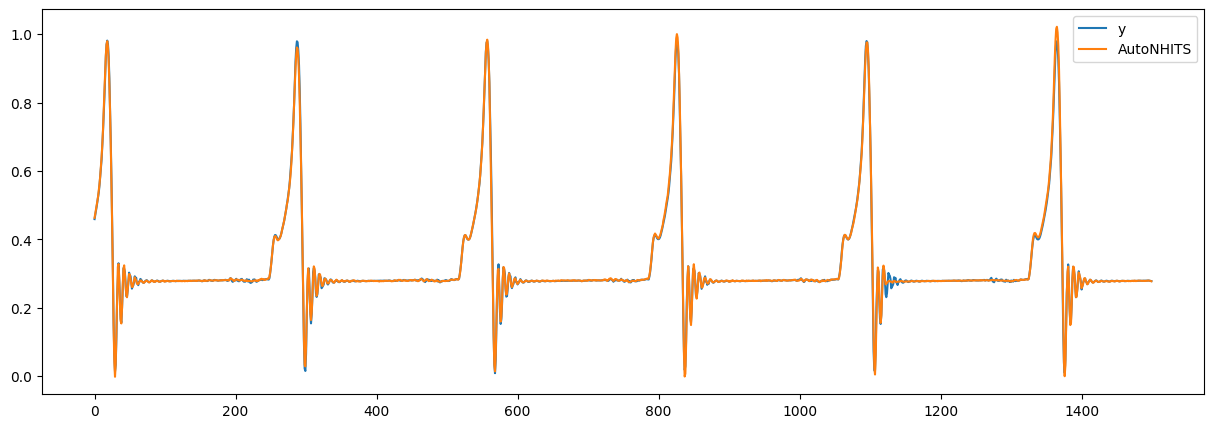

In [ ]:
exogenous_results[['y', 'AutoNHITS']].plot(figsize=(15, 5));

In [ ]:
scaler = joblib.load(f"{ROOT}/data/scaler.joblib")

In [ ]:
############
# Métricas
############

In [ ]:
##################################
# Retornar para a escala original
##################################

n_rows = len(exogenous_results)
dummy_df = pd.DataFrame(
    data={
        'pressure_1': [0]*n_rows,
        'pressure_2': [0]*n_rows,
        'pressure_3': [0]*n_rows,
        'pressure_4': [0]*n_rows,
        'pressure_5': [0]*n_rows,
        'pressure_6': [0]*n_rows,
        'pressure_7': [0]*n_rows,
        'gas_flow_rate': [0]*n_rows,
        'liquid_flow_rate': [0]*n_rows
    }
)

model_outputs_columns = [
    'y', # y_true
    'AutoNHITS'
]


original_scale_predictons = {}
for column in model_outputs_columns:
    dummy_df['liquid_flow_rate'] = exogenous_results[column]
    reverse_df = scaler.inverse_transform(dummy_df)
    original_scale_predictons[column] = reverse_df['liquid_flow_rate']


original_scale_df = pd.concat(
    [
        exogenous_results[['unique_id', 'ds']],
        pd.DataFrame(original_scale_predictons)
    ],
    axis=1
)

original_scale_df

,unique_id,ds,y,AutoNHITS
0,slug_flow,1501,91.592333,92.994329
1,slug_flow,1502,96.149750,97.616388
2,slug_flow,1503,101.114667,101.869979
3,slug_flow,1504,105.843333,106.228489
4,slug_flow,1505,111.156667,111.918246
...,...,...,...,...
1495,slug_flow,2996,22.713000,22.752119
1496,slug_flow,2997,22.696038,22.445265
1497,slug_flow,2998,22.470111,22.468313
1498,slug_flow,2999,22.205667,22.299579


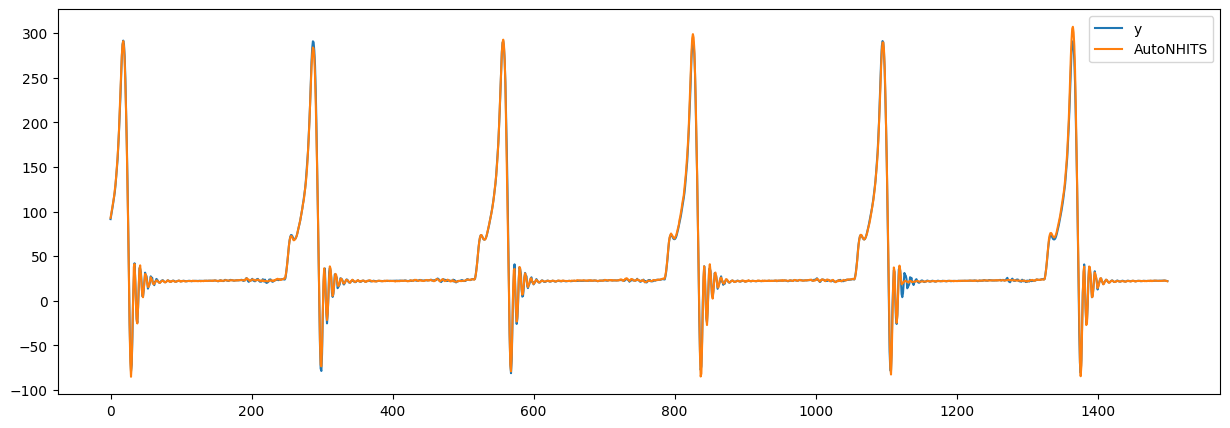

In [ ]:
original_scale_df[['y', 'AutoNHITS']].plot(figsize=(15, 5));

In [ ]:
y_true = original_scale_df['y']
y_pred = original_scale_df['AutoNHITS']

In [ ]:
print(f"RMSE: {math.sqrt(mean_squared_error(y_true, y_pred))}")
print(f"MAE: {mean_absolute_error(y_true, y_pred)}")

RMSE: 2.448190732459234
MAE: 1.1568633336300047
